In [12]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  0
Num CPUs Available:  1


## Modele Avance

A la différence du notebook précédent, ici les deux étapes servant à faire la prédiction vont être remplacée :
- La traduction du mot en vecteur (word embedding) ne sera plus assurée par un CountVectorizer (qui ne faisait que compter les mots dans la phrase) mais par un modèle déjà entrainé qui place chaque mot comme un point dans un espace de grande dimension (word2vec ou GloVe)
- L'étape de prédiction, qui était faite avec une régression logistique sera assurée par un réseau de neurone mis en bout de chaine du modèle de word embedding.

## Context
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

In [13]:
import pandas as pd

# import csv
raw_data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=['target', 'ids', 'date', 'flag', 'user', 'text'])
raw_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Content
It contains the following 6 fields:
1. target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: The id of the tweet
3. date: the date of the tweet
4. flag: The query. If there is no query, then this value is NO_QUERY.
5. user: the user that tweeted
6. text: the text of the tweet

In [14]:
sample_size = 1000 # Number of tweets to use for this notebook

data = raw_data.sample(sample_size).copy(deep=True)
data['target'] = data['target'].map(lambda x: 1 if x == 4 else 0).astype('bool')
data['ids'] = data['ids'].astype('str')
data['date'] = data['date'].astype('str') # We will convert them to date if useful later, now we just want to reduce the size of the dataframe
data['flag'] = data['flag'].astype('str')
data['user'] = data['user'].astype('str')
data['text'] = data['text'].astype('str')

In [15]:
for col in data.columns:
    print(col, data[col].dtype)
    print(data[col].head())
    print(data[col].value_counts())
    print('\n')

target bool
820492      True
139075     False
22323      False
132227     False
1270423     True
Name: target, dtype: bool
True     503
False    497
Name: target, dtype: int64


ids object
820492     1553740517
139075     1880715908
22323      1557461467
132227     1835705386
1270423    2000397819
Name: ids, dtype: object
1553740517    1
1835949567    1
1834182938    1
1966106185    1
1694677522    1
             ..
2003612938    1
2197999594    1
1824448835    1
2061541004    1
2176207642    1
Name: ids, Length: 1000, dtype: int64


date object
820492     Sat Apr 18 15:05:01 PDT 2009
139075     Fri May 22 02:14:31 PDT 2009
22323      Sun Apr 19 04:15:29 PDT 2009
132227     Mon May 18 06:34:46 PDT 2009
1270423    Mon Jun 01 22:01:42 PDT 2009
Name: date, dtype: object
Sat Apr 18 15:05:01 PDT 2009    1
Mon May 18 07:04:38 PDT 2009    1
Mon May 18 01:57:03 PDT 2009    1
Fri May 29 17:08:08 PDT 2009    1
Mon May 04 03:40:48 PDT 2009    1
                               ..
Tue Jun 02 06:50:5

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')
print(f"{len(stopwords)} stopwords in the original list")
[stopwords.remove(negative_word) for negative_word in ['t', 'against', 'no', 'nor', 'not', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]]
print(f"{len(stopwords)} stopwords after removing the negative words")

179 stopwords in the original list
137 stopwords after removing the negative words


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\barau\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\barau\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\barau\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [17]:
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
import re

# We should later implement the same preprocessing process [here](https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb)

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)    
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            #if word not in stopwordlist:
            if word not in stopwords:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
                
        processedText.append(tweetwords)        
    return processedText

In [18]:
import time

corpus = data['text']
t = time.time()
X = preprocess(corpus)
print(f"Preprocessing took {time.time()-t} seconds")

Preprocessing took 0.04400062561035156 seconds


In [19]:
from sklearn.model_selection import train_test_split

Y = data['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Now that the tweets are cleaned, we will create a dictionnary where every key is a number and value is a word and replace every word by its number in the tweets.
Then, we will padd these tweets in order to have a uniform length.

In [20]:
import pickle

tokenizer_folder = 'tokenizer'
tokenizer_name = f"tokenizer-{sample_size}.pickle"
tokenizer_path = f"{tokenizer_folder}/{tokenizer_name}"


if os.path.exists(tokenizer_folder):
    if os.path.exists(tokenizer_path):
        print("Loading tokenizer...")
        
        # Loading the model
        with open(tokenizer_path, 'rb') as handle:
            tokenizer = pickle.load(handle)

else:
    print("Building the tokenizer")
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(X)
    if not os.path.exists(tokenizer_folder):
        os.makedirs(tokenizer_folder)
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Building the tokenizer
Vocabulary Size : 2827


In [21]:
MAX_SEQUENCE_LENGTH = 180

X_train = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen = MAX_SEQUENCE_LENGTH) # Adding some space to match the lenght of every tweets
X_test = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (800, 180)
Testing X Shape: (200, 180)


In [22]:
from sklearn.model_selection import train_test_split
import time
# Word2vec
import gensim.downloader

# we could train the model but in order to save time, we will load a model already trained on 2B tweets ([see here](https://github.com/RaRe-Technologies/gensim-data))
glove_vectors = gensim.downloader.load('glove-twitter-25') # Already 104MB
VECTORS_DIM = 25 # because twitter-25

glove_vectors.most_similar('twitter')

print(f"Most similar to 'twitter': {glove_vectors.most_similar('twitter')}")

Most similar to 'twitter': [('facebook', 0.948005199432373), ('tweet', 0.9403423070907593), ('fb', 0.9342358708381653), ('instagram', 0.9104824066162109), ('chat', 0.8964964747428894), ('hashtag', 0.8885937333106995), ('tweets', 0.8878158330917358), ('tl', 0.8778461217880249), ('link', 0.8778210878372192), ('internet', 0.8753897547721863)]


On créé une liste de mots de notre tokenizer et on va y associer les vecteurs qu'on a trouvé dans le modèle qu'on vient de charger. La couche Embedding servira donc juste à associer les mots (leurs numéros) à leur vecteurs.

In [23]:
import numpy as np

# convert the wv word vectors into a numpy matrix that is suitable for insertion into our TensorFlow and Keras models
embedding_matrix = np.zeros((vocab_size, VECTORS_DIM))
for word, i in word_index.items():
    if glove_vectors.has_index_for(word):
        embedding_matrix[i] = glove_vectors.get_vector(word)

In [24]:
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=VECTORS_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)

Building the model
Epoch 1/10
1/1 [==============================] - 9s 9s/step - loss: 0.6938 - accuracy: 0.5050 - val_loss: 0.6886 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.6895 - accuracy: 0.5675 - val_loss: 0.6852 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.6833 - accuracy: 0.6000 - val_loss: 0.6787 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.6784 - accuracy: 0.6037 - val_loss: 0.6702 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 0.6723 - accuracy: 0.6025 - val_loss: 0.6619 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.6624 - accuracy: 0.6212 - val_loss: 0.6534 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 0.6495 - acc

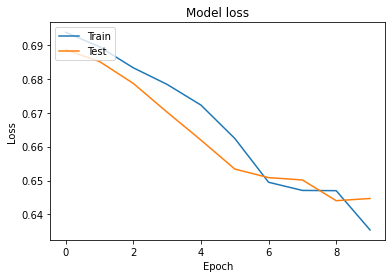

In [25]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

model_folder = "model"
model_name = f"model-{sample_size}.h5"
model_path = os.path.join(model_folder, model_name)

if os.path.exists(model_folder):
    if os.path.exists(model_path):
        print("Loading model...")
        model = tf.keras.models.load_model(model_path)

else:
    print("Building the model")

    # Creating the model
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(sequence_input, outputs)

    # Compiling
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

    #Fitting
    history = model.fit(X_train, Y_train, batch_size = 1024, epochs=10, validation_data=(X_test, Y_test), callbacks=[ReduceLROnPlateau])
    


    # save model
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    model.save(model_path)
    # save with pickle
    with open(f"{model_path}", 'wb') as handle:
        pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # Plotting the training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.gcf().set_facecolor('white')
    plt.show()


In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay



def evaluate_roc_det(Y_test, Y_pred):
    # two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    ax_roc = axs[0]
    ax_det = axs[1]

    ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
    ax_det.set_title("Detection Error Tradeoff (DET) curves")

    DetCurveDisplay.from_predictions(Y_test, Y_pred, ax=ax_det)
    RocCurveDisplay.from_predictions(Y_test, Y_pred, ax=ax_roc)
    plt.gcf().set_facecolor('white')
    plt.show()
    

def evaluate_confusion_matrix(Y_test, Y_pred, threshold, ax = None):
    binary_pred = np.where(Y_pred > threshold, 1, 0)
    ConfusionMatrixDisplay.from_predictions(Y_test, binary_pred, ax=ax)

7/7 [==============================] - 0s 24ms/step


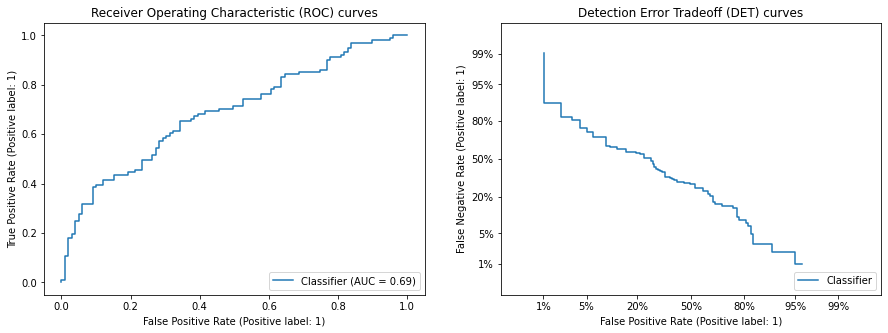

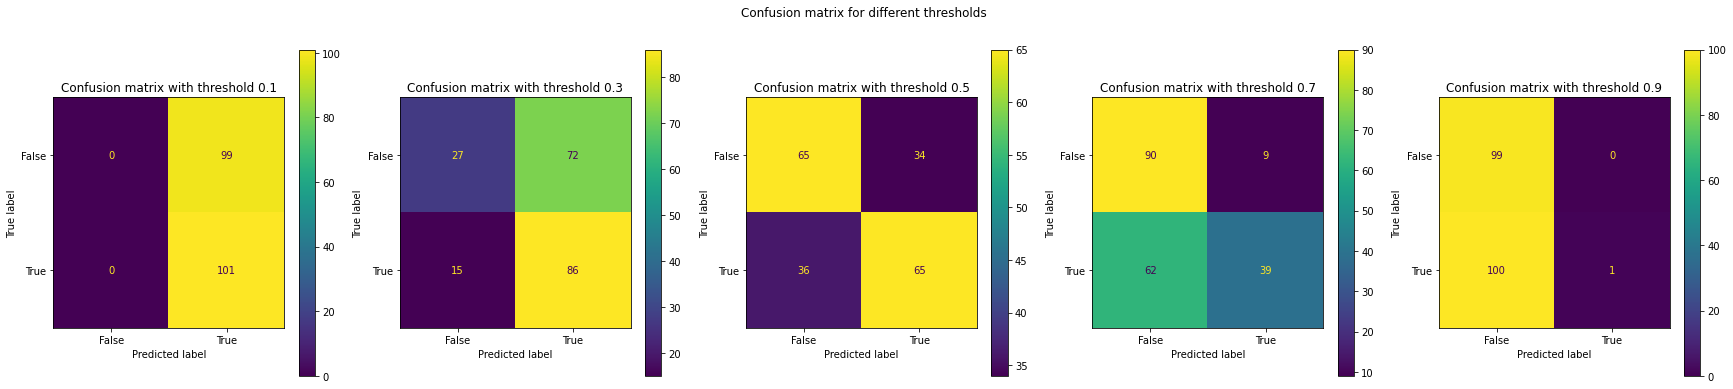

In [27]:
Y_pred = model.predict(X_test)

evaluate_roc_det(Y_test, Y_pred)

possible_thresholds = np.linspace(0.1, 0.9, 5)
fig, axs = plt.subplots(1, len(possible_thresholds), figsize=(6*len(possible_thresholds), 6))
fig.suptitle("Confusion matrix for different thresholds")

for threshold, ax in zip(possible_thresholds, axs.ravel()):
    evaluate_confusion_matrix(Y_test, Y_pred, threshold, ax = ax)
    ax.set_title(f"Confusion matrix with threshold {round(threshold, 1)}")
plt.gcf().set_facecolor('white')
plt.show()